# Classifying the language of the last name via RNN

The idea is to one hot encode characters and then create dense embeddings for them based upon some classification problem, such as predicting the next letter or predicting nationality of last name (a common example).

## Support code

In [106]:
import pandas as pd
import numpy as np
import math
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F
#from torch.nn.functional import softmax
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
np.set_printoptions(precision=2, suppress=True, linewidth=3000, threshold=20000)
from typing import Sequence

dtype = torch.float
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [107]:
def normal_transform(x, mean=0.0, std=0.01):
    "Convert x to have mean and std"
    return x*std + mean

def randn(n1, n2,
          device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'),
          dtype=torch.float,
          mean=0.0, std=0.01, requires_grad=False):
    x = torch.randn(n1, n2, device=device, dtype=dtype)
    x = normal_transform(x, mean=mean, std=std)
    x.requires_grad=requires_grad
    return x

In [218]:
def plot_history(history, yrange=(0.0, 5.00), figsize=(3.5,3)):
    plt.figure(figsize=figsize)
    plt.ylabel("Sentiment log loss")
    plt.xlabel("Epochs")
    loss = history[:,0]
    valid_loss = history[:,1]
    plt.plot(loss, label='train_loss')
    plt.plot(valid_loss, label='val_loss')
    # plt.xlim(0, 200)
    plt.ylim(*yrange)
    plt.legend(loc='lower right')
    plt.show()

## Load

Let's download [training](https://raw.githubusercontent.com/hunkim/PyTorchZeroToAll/master/data/names_train.csv.gz) and [testing](https://raw.githubusercontent.com/hunkim/PyTorchZeroToAll/master/data/names_test.csv.gz) data for last names.   This data set is a bunch of last names and the nationality or language. 

In [108]:
df_train = pd.read_csv("data/names_train.csv", header=None)
df_train.columns = ['name','language']
df_test = pd.read_csv("data/names_train.csv", header=None)
df_test.columns = ['name','language']

In [109]:
df_train.shape, df_test.shape

((13374, 2), (13374, 2))

In [110]:
df_train.head(2)

,name,language
0,Adsit,Czech
1,Ajdrna,Czech


## Clean

In [111]:
badname = df_train['name']=='To The First Page'
df_train[badname]

,name,language
8340,To The First Page,Russian
8341,To The First Page,Russian
8342,To The First Page,Russian
8343,To The First Page,Russian
8344,To The First Page,Russian
8345,To The First Page,Russian
8346,To The First Page,Russian
8347,To The First Page,Russian
8348,To The First Page,Russian
8349,To The First Page,Russian


In [112]:
comma = df_train['name'].str.contains(',') # might as well keep
df_train[comma]

,name,language
5976,"Jevolojnov,",Russian
6549,"Lytkin,",Russian


In [113]:
df_train[df_train['name'].str.contains("'")][:3] # there are ok so keep quote

,name,language
3609,Awak'Yan,Russian
4454,Dan'Ko,Russian
4471,Dar'Kin,Russian


In [114]:
badname = df_train['name']=='To The First Page'
df_train = df_train[~badname]

badname = df_test['name']=='To The First Page'
df_test = df_test[~badname]

In [115]:
df_train['name'] = df_train['name'].str.lower()
df_test['name'] = df_test['name'].str.lower()

In [116]:
def maxlen(strings:Sequence[str]) -> int:
    return max([len(l) for l in strings])

max_len = max(maxlen(df_train['name']), maxlen(df_test['name']))
max_len

19

## Split out validation set

In [117]:
X, y = df_train[['name']], df_train['language']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20)
X_test, y_test = df_test[['name']], df_test['language']

## Get vocab

In [118]:
def vocab(strings):
    letters = [list(l) for l in strings]
    V = set([c for cl in letters for c in cl])
    V = sorted(list(V))
    ctoi = {c:i for i, c in enumerate(V)}
    return V, ctoi

In [119]:
V, ctoi = vocab(X['name'])
ctoi

{' ': 0,
 "'": 1,
 ',': 2,
 'a': 3,
 'b': 4,
 'c': 5,
 'd': 6,
 'e': 7,
 'f': 8,
 'g': 9,
 'h': 10,
 'i': 11,
 'j': 12,
 'k': 13,
 'l': 14,
 'm': 15,
 'n': 16,
 'o': 17,
 'p': 18,
 'q': 19,
 'r': 20,
 's': 21,
 't': 22,
 'u': 23,
 'v': 24,
 'w': 25,
 'x': 26,
 'y': 27,
 'z': 28}

## Encode target language (class)

Get categories from training only, not valid/test sets. Then apply cats to those set y's.

In [120]:
y_train = y_train.astype('category').cat.as_ordered()
y_cats = y_train.cat.categories
y_cats

Index(['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German',
       'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish',
       'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese'],
      dtype='object')

In [121]:
y_train = y_train.cat.codes
y_train.values[:10]

array([ 4, 14,  4, 14,  4, 14, 14,  0, 14,  0], dtype=int8)

In [122]:
y_valid = pd.Categorical(y_valid, categories=y_cats, ordered=True).codes
y_test = pd.Categorical(y_test, categories=y_cats, ordered=True).codes

In [123]:
y_valid[:5], y_test[:5]

(array([14,  9, 14, 14, 14], dtype=int8), array([2, 2, 2, 2, 2], dtype=int8))

## One-hot encode each letter of each name

Each name becomes a matrix of size vocab_size x max_len. Each column represents a char and we pad with zeros out to max_len number of columns since tensors have to be same length in same dimension. 

This approach is wasteful in that it expands each word to len of longest but avoids having to pad explicitly, simplifying the training process.

In [124]:
def onehot(strings:Sequence[str], V, ctoi, max_len=None) -> torch.tensor:
    if max_len is None:
        max_len = maxlen(strings)
    X_onehot = torch.zeros(len(strings),len(V),max_len).double()
    for i,name in enumerate(strings):
        onehot = torch.zeros((len(V),max_len))
        for j,c in enumerate(name):
            onehot[ctoi[c],j] = 1
        X_onehot[i] = onehot
    return X_onehot

In [125]:
sample = ['cat','a','at'] # always debug with a small representative example
o = onehot(sample, *vocab(sample))
o

tensor([[[0., 1., 0.],
         [1., 0., 0.],
         [0., 0., 1.]],

        [[1., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[1., 0., 0.],
         [0., 0., 0.],
         [0., 1., 0.]]], dtype=torch.float64)

In [126]:
o[0,1].reshape(-1,1)

tensor([[1.],
        [0.],
        [0.]], dtype=torch.float64)

In [127]:
X_train_onehot = onehot(X_train['name'], V, ctoi, max_len=max_len)
X_train_onehot[0].shape

torch.Size([29, 19])

In [128]:
X_valid_onehot = onehot(X_valid['name'], V, ctoi, max_len=max_len)
X_valid_onehot[0].shape

torch.Size([29, 19])

## RNN model

Switching to W, U, V notation from $W_hh$ etc... from [Goodfellow and Yoshua Bengio and Aaron Courville book](https://www.deeplearningbook.org/contents/rnn.html)

We have a sequence of one-hot vectors for each word and need to predict a language for each sequence.  We need to know: vocab size (len of one hots), hidden len, and the number of target classes (langs).

We must combine a name's onehots into a single vector representing word then use a simple dense linear layer to make a prediction

$$
h^{(t)} = \text{ReLU}( W h^{(t-1)} + U x^{(t)} )
$$

where $t$ iterates through name length (or max pad length).

Note this is same as concatenating old state and current input vector and applying a single $W$ matrix of size nhidden x (nhidden+|V|):

$$
h^{(t)} = \text{ReLU}( W [h^{(t-1)};x^{(t)}] )
$$

The output is avail at every char but we only need the last one:

$$
y^{(t)} = V h^{(t)}
$$

This $V$ acts like the last dense linear layer which converts the hidden state to likelihood of each target class.

*What are the embeddings?* I think those are the final $h^{(t)}$ vectors, one of which is computed per name.  What are char-vec embeddings? Maybe $U$?

In [140]:
class LastNameRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LastNameRNN, self).__init__()
#         print("Model: ",input_size, hidden_size, output_size)
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.W  = randn(hidden_size, hidden_size, std=0.01).double()
        self.U  = randn(hidden_size, input_size, std=0.01).double()
        self.V  = randn(output_size, hidden_size, std=0.01).double()
        self.W  = nn.Parameter(self.W)
        self.U  = nn.Parameter(self.U)
        self.V  = nn.Parameter(self.V)

    def forward(self, X):
#         print("X", X.shape)
        batch_size = X.shape[0]
        namelen = X.shape[2]
        # record softmax vec of output_size for each record
        o = torch.zeros((batch_size, self.output_size)).double()
        for i in range(batch_size):
            # Reset hidden state (history) at start of every record
            # Use same W and U matrices for all records until SGD update step
            h = torch.zeros((self.hidden_size, 1)).double()
            for j in range(namelen):  # for all chars in max name length
#                 print(h.shape, X[i].shape, X[i,:,j].shape, self.U.shape)
                h = self.W.mm(h) + self.U.mm(X[i,:,j].reshape(-1,1))
                h = torch.relu(h)  # better than sigmoid for vanishing gradient
            # we now have an h vector that is the embedding for the ith record
            # we have encoded/embedded the X[i] record into h
            # compute an output value, one per record
            ot = self.V.mm(h)
#             o[i] = F.softmax(ot.reshape(-1))
            o[i] = ot.reshape(-1)
        return o

In [141]:
# test model
rnn = LastNameRNN(input_size=len(V),hidden_size=10,output_size=len(y_cats)).to(device)
y_pred = rnn(torch.tensor(X_train_onehot[:100],device=device)).detach().cpu()
y_pred

/Users/parrt/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


tensor([[ 1.7546e-28,  4.4825e-29, -1.2455e-28,  ..., -3.0759e-28,
         -4.5513e-28, -2.9089e-28],
        [-8.8963e-29, -1.1068e-28, -3.4169e-29,  ..., -1.1413e-28,
         -4.1148e-28, -2.5008e-28],
        [ 5.9256e-31,  1.0017e-31, -2.0012e-31,  ..., -8.1103e-31,
         -1.0096e-30, -2.6456e-31],
        ...,
        [ 5.7379e-33,  9.2860e-34, -1.7687e-33,  ..., -7.7621e-33,
         -9.5742e-33, -2.4529e-33],
        [ 1.2201e-31,  6.5266e-32, -2.7634e-32,  ..., -1.4205e-31,
         -9.6080e-32, -8.1479e-32],
        [ 8.4872e-21,  1.8219e-21, -4.0641e-21,  ..., -7.1615e-21,
         -9.2438e-21, -1.3181e-21]], dtype=torch.float64)

## Train

In [234]:
def ctrain(model:nn.Module, train_data:TensorDataset, valid_data:TensorDataset,
           epochs=350,
           test_size=0.20,
           learning_rate = 0.002,
           batch_size=32,
           weight_decay=1.e-4,
           loss_fn=F.cross_entropy,
           metric=accuracy_score,
           print_every=30):
    "Train a regressor"
    history = []
    train_loader = DataLoader(train_data, batch_size=batch_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
#     optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    for ei in range(epochs): # epochs
        for bi, (batch_x, batch_y) in enumerate(train_loader): # mini-batch
#             if len(batch_x)!=batch_size:
#                 print(f"\tBatch {bi:3d} len {len(batch_x)}")
            y_prob = model(batch_x)
#             print("y pred", y_prob, "batch_y", batch_y)
            loss = loss_fn(y_prob, batch_y)

            optimizer.zero_grad()
            loss.backward() # autograd computes U.grad and M.grad
            optimizer.step()

        with torch.no_grad():
            loss        = loss_fn(model(train_data.tensors[0]), train_data.tensors[1])
            loss_valid  = loss_fn(model(valid_data.tensors[0]), valid_data.tensors[1])
            y_prob = model(train_data.tensors[0])
            y_prob = F.softmax(y_prob, dim=1)
            y_pred = torch.argmax(y_prob, dim=1)
            metric_train = metric(y_pred, train_data.tensors[1].cpu())
            y_prob = model(valid_data.tensors[0])
            y_prob = F.softmax(y_prob, dim=1)
            y_pred = torch.argmax(y_prob, dim=1)
            metric_valid = metric(y_pred, valid_data.tensors[1].cpu())

        history.append( (loss, loss_valid) )
        if ei % print_every == 0:
            print(f"Epoch {ei:3d} loss {loss:7.4f}, {loss_valid:7.4f}   {metric.__class__.__name__} {metric_train:4.3f}, {metric_valid:4.3f}")

    history = torch.tensor(history)
    return model, history

Epoch   0 loss  2.2899,  2.3530   function 0.361, 0.349
Epoch   1 loss  2.1507,  2.2136   function 0.422, 0.414
Epoch   2 loss  1.7340,  1.8701   function 0.471, 0.465
Epoch   3 loss  1.6814,  1.7857   function 0.474, 0.465
Epoch   4 loss  1.6316,  1.7678   function 0.474, 0.466
Epoch   5 loss  1.6659,  1.7666   function 0.471, 0.470
Epoch   6 loss  1.5540,  1.7233   function 0.478, 0.474
Epoch   7 loss  1.5404,  1.7028   function 0.478, 0.475
Epoch   8 loss  1.8183,  1.9057   function 0.474, 0.475
Epoch   9 loss  2.0940,  2.1950   function 0.384, 0.368


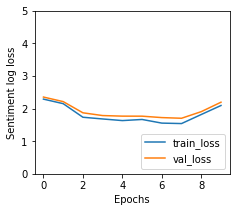

In [236]:
rnn = LastNameRNN(input_size=len(V),
                  hidden_size=100,
                  output_size=len(y_cats)).to(device)
subset=1000
train = TensorDataset(X_train_onehot[:subset], torch.tensor(y_train[:subset].values).long())
valid = TensorDataset(X_valid_onehot[:subset], torch.tensor(y_valid[:subset]).long())
model, history = ctrain(rnn, train, valid,
#                         loss_fn=torch.nn.BCELoss(),
                        loss_fn=F.cross_entropy,
                        metric=accuracy_score,
                        epochs=10,
                        learning_rate=.1,
                        weight_decay=0.00001,
                        batch_size=64,
                        print_every=1)

plot_history(history, yrange=(0,5))

## Errors

For TensorDataset, if you see `TypeError: 'int' object is not callable`, it means you've passed a numpy array.

If it says "expected Long got Char", it might mean int8 not char.

In [204]:
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5)
input, input.shape

(tensor([[-0.0626,  0.3605,  0.5261, -1.7562,  0.7937],
         [-0.1773, -0.1990,  0.2704, -0.3907, -1.0118],
         [-1.4102,  1.1392, -0.4578,  0.1704, -0.3034]]), torch.Size([3, 5]))

In [201]:
target = torch.empty(3, dtype=torch.long).random_(5)
target, target.shape

(tensor([0, 2, 3]), torch.Size([3]))

In [200]:
output = loss(input, target)
output

tensor(1.8019)